In [2]:
!nvidia-smi

Fri Apr  9 13:33:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   33C    P8    10W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   37C    P8    24W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "4"

In [4]:
%pylab inline
from routines import *

Populating the interactive namespace from numpy and matplotlib
batch mode...


/home/ben.horowitz/DHOD/nb/routines.py:212: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  logMmin=ed.Deterministic(11.35, name='logMmin'),


In [5]:
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

from tensorflow_probability import edward2 as ed

import diffhod

from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, Zheng07SatsPoisson,NFWProfile

#from flowpm.utils import cic_paint
import tensorflow as tf



In [6]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < 128]
halo_table = halo_table[halo_table['halo_y'] < 128]
halo_table = halo_table[halo_table['halo_z'] < 128]

tf_halocat = {k: tf.stop_gradient(tf.convert_to_tensor(halo_table[k], dtype=tf.float32)) for k in halo_table.colnames}



In [7]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', redshift =-0, 
                                        modulate_with_cenocc=True)

In [8]:
# Let's see what are the parameters of the model


def loss(x):
    HOD = sample(tf_halocat, 12.02, 0.26, 11.38, 13.31, x)
    ps = Power_Spectrum([128,128,128],[128,128,128],
         kmin=tf.constant(0.045),dk=tf.constant(.049))
    output = ps.pk_tf(HOD)
    return output[1][0]
x = tf.Variable([00000.908])
L = loss(x)

print(L)
#loss_ar.append(np.array(L))
def get_grads(x):
    with tf.GradientTape(persistent=True) as g:
     #  g.watch(x)
       L = loss(x)
    dL_dx = g.gradient(L, x)
    return dL_dx
#a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
grad = get_grads(x)
print(grad)

In [9]:
{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

HOD = sample(tf_halocat, 12.02, 0.26, 11.38, 13.31, 01.06)
ps = Power_Spectrum([128,128,128],[128,128,128],
         kmin=tf.constant(0.045),dk=tf.constant(.049))
output = ps.pk_tf(HOD)

Tensor("Pow:0", shape=(), dtype=float32)
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
(1, 139905, 3) (1, 139905)
(1, 4756770, 3) (1, 4756770)


In [203]:
%timeit hod(tf_halocat, 12.02, 0.26, 11.38, 13.31, 01.06)

78 ms ± 579 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
HOD_fid = np.load("central_hod.npy") + np.load("sat_hod.npy") 
HOD_fid.sum(),np.array(HOD).sum()

(10096.002, 10034.502)

In [11]:

out = hod(tf_halocat, [12.02,13.02], [0.26,0.26], [11.38,11.38], [13.31,13.31], [01.,1.11])
#hod(tf_halocat, [12.02,11.02], [0.26,0.26], [11.38,11.38], [13.31,13.31], [01.06,1.11])

Tensor("Pow:0", shape=(2,), dtype=float32)


In [12]:
np.array(out["n_sat"]).sum(axis=0).sum(axis=-1)

array([2182.681 , 1571.1527], dtype=float32)

In [13]:
HOD = sample(tf_halocat, [12.02,11.02], [0.26,0.26], [11.38,11.38], [13.31,13.31], [01.06,1.11])
ps = Power_Spectrum([128,128,128],[128,128,128],
         kmin=tf.constant(0.045),dk=tf.constant(.049))
output = ps.pk_tf(HOD)

Tensor("Pow:0", shape=(2,), dtype=float32)
(2, 139905, 3) (2, 139905)
(2, 4756770, 3) (2, 4756770)


In [142]:
pk_ht = np.load("pk_out.npy")
ps = Power_Spectrum([128,128,128],[128,128,128],
             kmin=tf.constant(0.045),dk=tf.constant(.049))
pk_obs = pk_ht[0][:20]
cov_pk = np.cov(pk_ht.T)
cinv_pk = np.linalg.inv(cov_pk)
@tf.function
def loss(X):
    X = tf.transpose(X)
    HOD = sample(tf_halocat, X[0],X[1],X[2],X[3],X[4])
    output = ps.pk_tf(HOD)
    pkr = output[1]
    #print(pkr.shape)
    return tf.reduce_sum(-1/2*((pk_obs[:20] - pkr[:,:20])**2.0/np.diag(cov_pk)[:20]),axis=1)


In [143]:
{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

HOD = sample(tf_halocat, [12.02,13.02], [0.26,0.26], [11.38,11.38], [13.31,13.31], [01.06,1.06])
print(HOD.shape)
ps = Power_Spectrum([128,128,128],[128,128,128],
         kmin=tf.constant(0.045),dk=tf.constant(.049))
output1a = ps.pk_tf(tf.reshape(HOD[0],(-1,128,128,128)))
output2a = ps.pk_tf(tf.reshape(HOD[1],(-1,128,128,128)))

(2, 128, 128, 128)


In [144]:
#hod(tf_halocat, [12.02,12.02], [0.26,0.26], [11.38,11.38], [13.31,13.31], [01.06,1.06])

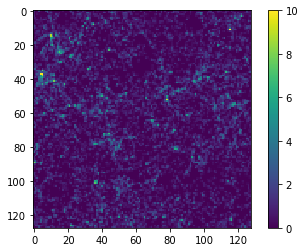

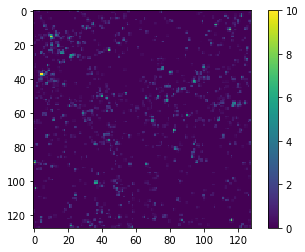

In [145]:
imshow(np.array(HOD[0]).sum(axis=0),vmax=10)
colorbar()
show()
imshow(np.array(HOD[1]).sum(axis=0),vmax=10)
colorbar()
show()

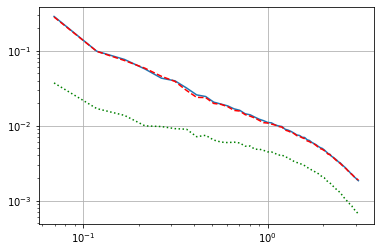

In [146]:
loglog(output1a[0],output1a[1][0])
loglog(output2a[0],output2a[1][0],"g:")
grid()
loglog(output[0],pk_ht[0], "r--")


In [147]:
loss(np.array([[13.02,12.02,11.02], [0.26,0.26,0.26], [11.38,11.38,11.38], [13.31,13.31,13.31], [01.06,01.06,1.]],dtype=np.float32).T)



<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.1697657e+03, -6.2032490e+00, -3.9405566e+05], dtype=float32)>

In [148]:
x = tf.Variable([12.02,  0.26, 11.38, 13.31,  0000001.9900010])
print(loss(x))#[[12.02,12.02,], [0.26,0.26,], [11.38,11.38,], [13.31,13.31,], [x,x,]]))
#loss_ar.append(np.array(L))
def get_grads(x):
    with tf.GradientTape(persistent=True) as g:
     #  g.watch(x)
       L = loss(x)
    dL_dx = g.gradient(L, x)
    return dL_dx
#a = tf.constant((np.array([[12.5,0.5,11.38,13.01, x]],dtype=np.float32)))
grad = get_grads(x)
print(grad)

tf.Tensor([-7876.243], shape=(1,), dtype=float32)
tf.Tensor([ 21898.172   -8259.796     289.2386  65475.13   -18103.209 ], shape=(5,), dtype=float32)


In [149]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tf.enable_v2_behavior()

num_burnin_steps = int(3e2) #oops....
num_chains = 3


adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=loss,
        num_leapfrog_steps=3,
        step_size=.015), #can play a lot with this number...
    num_adaptation_steps=int(num_burnin_steps * 0.8))


In [214]:
int(num_burnin_steps * 0.8)

240

In [150]:
#start spread out around some point
var = (np.random.random([num_chains, 5])-0.5)*np.array([0.1,0.2,0.1,0.1,0.1])*0.10

In [151]:

num_results = 10000

# Initial state of the chain
init_state = tf.Variable(np.ones([num_chains, 5], dtype=dtype)*np.array([12.02,  0.26, 11.38, 13.31,  1.06],dtype=float32)+var,dtype=float32)

@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    return samples,is_accepted#sample_mean, sample_stddev, is_accepted


In [200]:
%timeit loss(init_state)

874 ms ± 45.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
loss(init_state)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.8925323, -2.8852272, -4.809441 ], dtype=float32)>

In [ ]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

In [154]:
#time in minutes, since math is hard
print(run_time/60)

709.548739027977


In [155]:

q[0],q[0]-q[-1]


(<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
 array([[11.95459   ,  0.369131  , 11.389717  , 13.487482  ,  1.0885705 ],
        [12.017677  ,  0.34780723, 11.300115  , 13.334584  ,  1.0698898 ],
        [12.086612  ,  0.44369534, 11.250198  , 13.302096  ,  1.0218956 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(3, 5), dtype=float32, numpy=
 array([[-0.18777752, -0.25389776,  0.3334942 ,  0.1142416 , -0.03699088],
        [ 0.02501011,  0.20543033,  0.2314415 , -0.05614758, -0.10567665],
        [ 0.0069952 ,  0.04827836, -0.26753712,  0.08747101,  0.1015327 ]],
       dtype=float32)>)

In [156]:
import corner

In [161]:
MCMC = np.load("MCMC_Output_040521.npy")

In [173]:
#np.save("HMC_output_041621.npy",q)

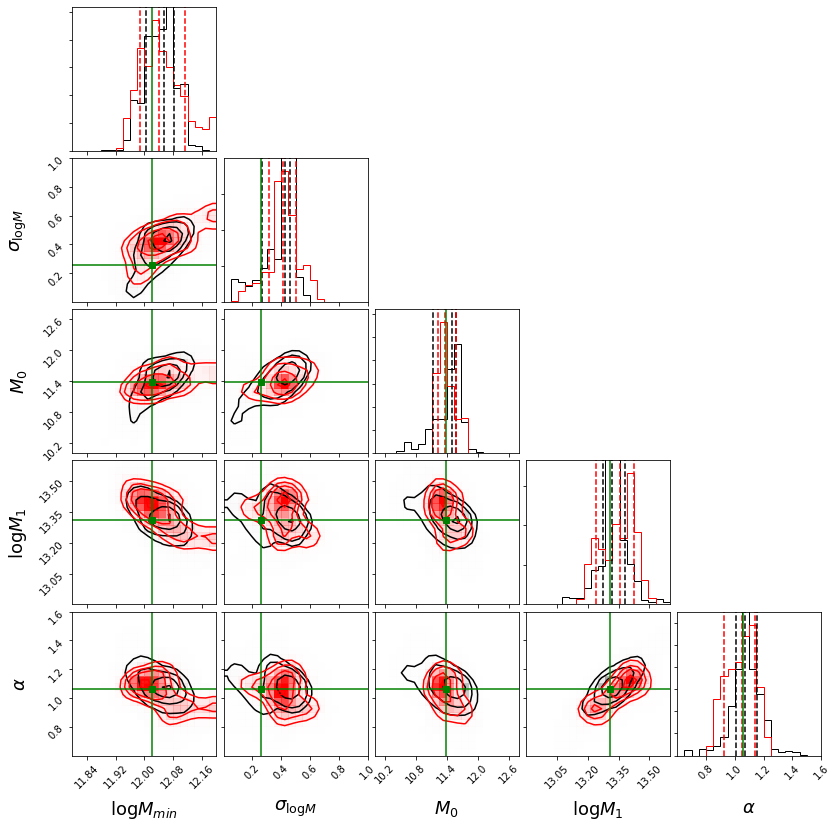

In [213]:
levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

figure = corner.corner(np.array(MCMC)[:,100:].reshape(-1,5),labels = [r"$\log M_{min}$", r"$\sigma_{\log M}$", r"$M_0$",r"$\log M_1$", r"$\alpha$"],label_kwargs={"fontsize":18} ,
                    levels=levels,quantiles=[0.16, 0.5, 0.84],#show_titles=True,
                       smooth=1.0,plot_datapoints=False,
                       range=[[11.8,12.2],[0.0,1.0],[10,12.8],[12.9,13.6],[0.60,1.6]])
                     # range=[[11.8,12.2],[0.0,1.0],[10,12.8],[12.9,13.6],[0.60,1.6]])
                       # range=[[12.6,13.5],[0.0,1.0],[10,12.8],[12.4,13.8],[0.60,1.6]])
                      #,range=[[11.6,12.5],[0.0,1.0],[10,12.8],[12.4,13.8],[0.60,1.6]])
            
corner.corner(np.array(q)[:,:].reshape(-1,5),fig=figure, labels = [r"$\log M_{min}$", r"$\sigma_{\log M}$", r"$M_0$",r"$\log M_1$", r"$\alpha$"],label_kwargs={"fontsize":18} ,
                       levels=levels,quantiles=[0.16, 0.5, 0.84],#show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       smooth=1.0,plot_datapoints=False,
                       range=[[11.8,12.2],[0.0,1.0],[10,12.8],[12.9,13.6],[0.60,1.6]], color='red')
                     # range=[[11.8,12.2],[0.0,1.0],[10,12.8],[12.9,13.6],[0.60,1.6]])
                       # range=[[12.6,13.5],[0.0,1.0],[10,12.8],[12.4,13.8],[0.60,1.6]])
                      #,range=[[11.6,12.5],[0.0,1.0],[10,12.8],[12.4,13.8],[0.60,1.6]])
            
ndim = 5
ndim = 5
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")
        
plt.savefig("HMC_MCMC_compar.pdf")
